In [1]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [2]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [3]:
# Hyperparameters
batch_size = 32
num_classes = 10
epochs = 300
l = 6
num_filter = 30
compression = 1.0
# dropout_rate = 0.2

In [6]:
img_width

32

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170508288/170498071 [==============================] - 2s 0us/step


In [26]:
# Normalize the images
x_train, x_test = X_train / 255.0, X_test / 255.0

In [28]:
# Perform Image Augmentation
from keras.preprocessing.image import ImageDataGenerator

# Reference - https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(
        x_train, y = y_train,
        batch_size=32) 

# # this is a similar generator, for validation data
# validation_generator = test_datagen.flow(
#         X_test, y = y_test,
#         batch_size=50)



In [ ]:
X_train.shape

(50000, 32, 32, 3)

In [ ]:
X_test.shape

(10000, 32, 32, 3)

In [29]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    # output = layers.Dense(num_classes, activation='softmax')(flat)
    conv = layers.Conv2D(num_classes, (2,2), strides=(1,1), activation='softmax')(AvgPooling)
    output = layers.Flatten()(conv)
    return output

In [30]:
# num_filter = 12
# dropout_rate = 0.2
num_filter = 34
dropout_rate = 0.0

l = 6
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, 64, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)
# num_filter = 12
# dropout_rate = 0.0

# l = 6
# input = layers.Input(shape=(img_height, img_width, channel,))
# First_Conv2D = layers.Conv2D(32, (5,5), use_bias=False ,padding='same')(input)

# First_Block = denseblock(First_Conv2D, 10, dropout_rate)
# First_Transition = transition(First_Block, 64, dropout_rate)

# Second_Block = denseblock(First_Transition, 10, dropout_rate)
# Second_Transition = transition(Second_Block, 32, dropout_rate)

# Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
# Third_Transition = transition(Third_Block, 32, dropout_rate)

# Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
# output = output_layer(Last_Block)

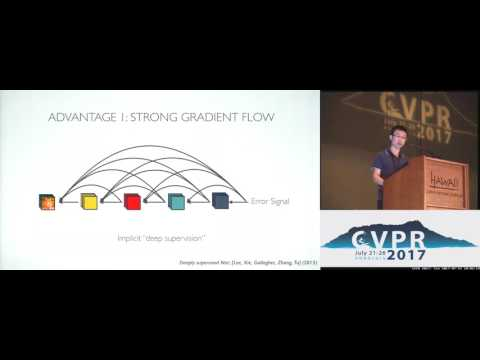

In [ ]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [ ]:
model.load_weights('my_model_weights.h5')

In [31]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 34)   918         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 34)  136         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 34)   0           ['batch_normalization[0][0]']

In [ ]:
print(len(model.layers))

115


In [33]:
# utility functions
# decay of weights
def reduceLearningRate(epoch, lr):
    if (epoch+1) % 10 == 0 and epoch > 9:
        return 0.95* lr
    return lr

# Custom callbacks
import tensorflow as tf
from sklearn.metrics import roc_auc_score, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TerminateOnNaN


# decay learning rate by 5% for every 10th epoch
lrschedule = LearningRateScheduler(reduceLearningRate, verbose=1)
# decay learning rate by 10% If validation accuracy at that epoch is less than previous 3 epochs' accuracy
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=3, min_delta=0.0001, mode = 'auto')

NanStop = TerminateOnNaN()
checkpoint = tf.keras.callbacks.ModelCheckpoint('weights{epoch:08d}.h5', save_weights_only=True, save_freq=5)

# https://stackoverflow.com/questions/59563085/how-to-stop-training-when-it-hits-a-specific-validation-accuracy
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True

stop_training = MyThresholdCallback(threshold=0.9)

In [34]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate= 0.01, momentum=0.9, nesterov=True),
              metrics=['accuracy'])

In [35]:
print(batch_size)

32


In [36]:
# model.fit(X_train, y_train,
#                     batch_size=batch_size,
#                     epochs=epochs,
#                     verbose=1, 
#                     validation_data=(X_test, y_test))
tf.keras.backend.clear_session()

steps_per_epoch = x_train.shape[0] // batch_size
callbacks_list = [NanStop, lrschedule, reduce_lr, checkpoint, stop_training]
model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        batch_size = batch_size,
        epochs=200,
        validation_data=(x_test, y_test),
        callbacks= callbacks_list)
model.save_weights('first_try.h5')


Epoch 00001: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 1/200
1562/1562 [==============================] - 125s 78ms/step - loss: 1.7434 - accuracy: 0.3685 - val_loss: 2.1275 - val_accuracy: 0.3725 - lr: 0.0100

Epoch 00002: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 2/200
1562/1562 [==============================] - 122s 78ms/step - loss: 1.3828 - accuracy: 0.5014 - val_loss: 1.3520 - val_accuracy: 0.5362 - lr: 0.0100

Epoch 00003: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 3/200
1562/1562 [==============================] - 122s 78ms/step - loss: 1.1870 - accuracy: 0.5767 - val_loss: 1.3202 - val_accuracy: 0.5691 - lr: 0.0100

Epoch 00004: LearningRateScheduler setting learning rate to 0.009999999776482582.
Epoch 4/200
1562/1562 [==============================] - 122s 78ms/step - loss: 1.0476 - accuracy: 0.6290 - val_loss: 0.9373 - val_accuracy: 0.6816 - lr: 0.0100

Epoch 00005: LearningRa

In [ ]:
# Test the model --------- original
score = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 66s 7ms/sample - loss: 1.4938 - accuracy: 0.4969
Test loss: 1.493803402900696
Test accuracy: 0.4969


In [ ]:
# Test the model 
score = model.evaluate(x_test, y_test, verbose=1, use_multiprocessing=True, steps=10000, callbacks= callbacks_list)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 68s 7ms/step - loss: 0.3237 - accuracy: 0.9018


In [ ]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")